## Using Linear Boundaries to Determine Alarm Metrics 

In [1]:
# dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# read in data
df = pd.read_csv("../data/labelled_data.csv")
df.head()

,Total Volume,Total Fails,Labels
0,1,0,1
1,2,0,1
2,3,0,1
3,4,0,1
4,5,0,1


### Classification  
The goal of this section is to use a model to find a linear decision boundary and modify that boundary so that we can encompasses the non-outliers very tightly.  The coefficients and intercepts of this tight fitting line will represent optimum alarm metrics or at least overly tight parameters that may also need need a small margin added.  

Since this process can be automated, the alarm parameters can be calculated and recalculated very easily even if there are hundreds or even thousands of similar alarms.  

In [3]:
# features and targets
X = df[['Total Volume','Total Fails']].values
y = df['Labels'].values

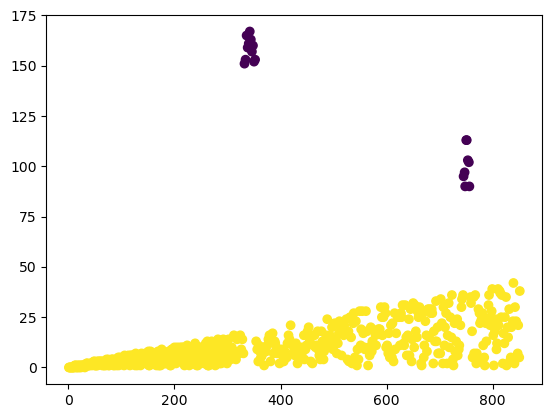

In [4]:
# dependencies
from sklearn.linear_model import LogisticRegression

# create a logistic regression model
model = LogisticRegression(C=4,solver='liblinear',penalty='l1')

# fit the model to the training data
model.fit(X, y)

# make predictions on the test data
predictions = model.predict(X)

# plot data with predicitons as colors
plt.scatter(df['Total Volume'], df['Total Fails'], c=predictions)

Text(0.5, 1.0, 'Logistic Regression Decision Boundary')

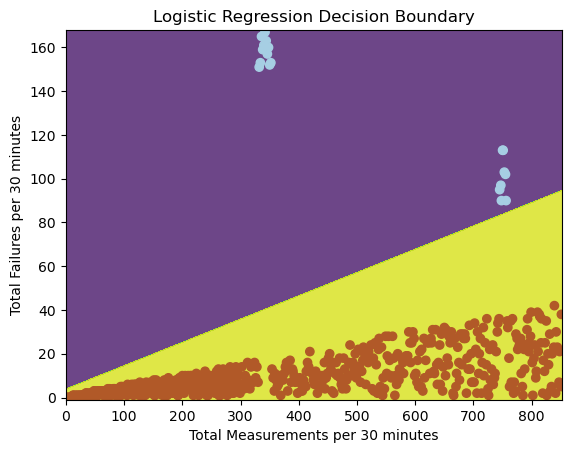

In [5]:
# Plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Total Measurements per 30 minutes')
plt.ylabel('Total Failures per 30 minutes')
plt.title('Logistic Regression Decision Boundary')

In [6]:
# dependencies  
from sklearn.svm import SVC

# create a Support Vector Classifier (SVC) model
model = SVC(kernel='linear', decision_function_shape="ovr", class_weight={1: 100000, -1: 1})  # Using a linear kernel for simplicity

# fit the model to the training data
model.fit(X, y)

# make predictions on the test data
predictions = model.predict(X)

# print parameters
print('Coefficients: ', model.coef_)
print('Intercept: ', model.intercept_)

Coefficients:  [[ 0.00184582 -0.03845458]]
Intercept:  [1.06612376]


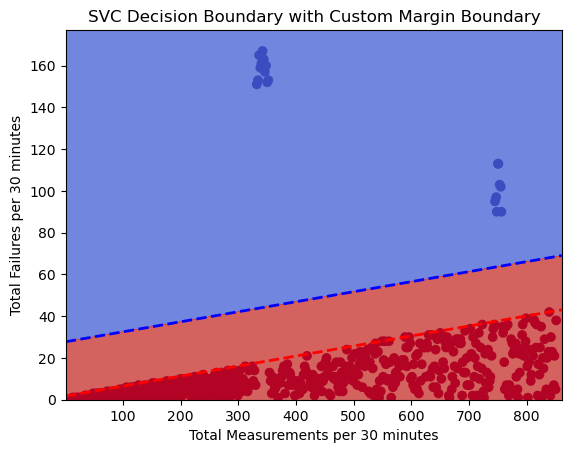

Model Coefficients:  [[ 0.00184582 -0.03845458]]
Model Intercept:  [1.06612376]
Corrected Boundary Intercept:  [27.72423551]
Corrected Lower Margin Intercept:  [1.728]

Minimum Alarms per 30 minutes before Alert can Occur:  1.728
Minimum Fraction Successful per 30 minutes before Alert can Occur:  0.952


In [8]:
# plot the decision boundary
def plot_decision_boundary(X, y, model, title):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    x_range = np.arange(x_min, x_max+10, h)
    y_range = np.arange(y_min, y_max+10, h)

    xx, yy = np.meshgrid(x_range,y_range )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # calc main boundary using original X values
    x_range_max = X[:,0]
    y_boundary = -(model.coef_[0][0] / model.coef_[0][1]) * x_range_max - model.intercept_ / model.coef_[0][1]
    # find difference between y of boundary and y of data
    diff_y = [ i[1] - i[0] if i[2]==1 else 1000 for i in zip(X[:,1], y_boundary, predictions)]
    # find smallest difference
    least_separation = min(diff_y)
  
    # calc lower boundary using evenly spaced X valeus
    y_calc = -(model.coef_[0][0] / model.coef_[0][1]) * x_range - model.intercept_ / model.coef_[0][1]
    decision_boundary = np.array(list(zip(x_range, y_calc)))

    # # method one - calculate lowerbounds  
    # w_new = model.coef_[0][0] / (np.sqrt(np.sum(model.coef_[0]**2)))
    # margin = least_separation/ np.sqrt(np.sum(model.coef_[0]**2))
    # y_lowerbound = decision_boundary - w_new*margin

    # plot boundary 
    plt.plot(decision_boundary[:,0], decision_boundary[:,1] , 'b--', linewidth=2)

    # plot lower margin 
    plt.plot(decision_boundary[:,0], decision_boundary[:,1] - least_separation, 'r--', linewidth=2)

    # plot scatter plot
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

    # complete plot area
    plt.xlabel('Total Measurements per 30 minutes')
    plt.ylabel('Total Failures per 30 minutes')
    plt.title(title)
    plt.savefig('../images/svc-lower-margin.png')
    plt.show()

    # print model information
    print('Model Coefficients: ', model.coef_)
    print('Model Intercept: ', model.intercept_)
    print('Corrected Boundary Intercept: ', -(model.intercept_/model.coef_[0][1]) )
    print('Corrected Lower Margin Intercept: ', -(model.intercept_/model.coef_[0][1]) - least_separation)

    # print meaning of model parameters in relation to 
    print()
    print('Minimum Alarms per 30 minutes before Alert can Occur: ', round((-(model.intercept_/model.coef_[0][1]) - least_separation)[0],3) )
    print('Minimum Fraction Successful per 30 minutes before Alert can Occur: ', round(1 - ( -1 * model.coef_[0][0] / model.coef_[0][1]),3) )

plot_decision_boundary(X, y, model, 'SVC Decision Boundary with Custom Margin Boundary')